# Prova Final de Business Analytics

## Importar os Dados e Análises Iniciais

In [1]:
import pandas as pd
import researchpy as rp
import datetime
from datetime import date
from datetime import datetime
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import average_precision_score
from matplotlib import pyplot
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import operator
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as pl
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import OneHotEncoder
import re
from sklearn.feature_selection import RFE
from sklearn.metrics import make_scorer
from scipy.stats import ks_2samp
from imblearn.over_sampling import SMOTENC


pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_excel('blu365_dataset_estudodecaso.xlsx')

In [3]:
display(df)
df.columns

,datadisparo,ddd,sms_entregue,sms_enviado,sms_naoentregue,sms_rejeitado,sms_invalido,data_atraso,valor,operadora,qtd_hist_acessos,data_maisrecente_acesso,data_maisantiga_acesso,sms_total_tent,idade,genero,compradoronline,vendedoronline,utilizacaoweb,rendaestimada,acesso,acordo
0,2020-05-19,62,0,0,0,0,0,2019-05-24,126.21,Claro,0,NaT,NaT,0,22.0,M,H,H,H,NaN,0,0
1,2020-04-27,67,3,0,0,0,0,2017-04-14,244.29,Vivo,0,NaT,NaT,3,56.0,F,D,H,D,ATE 2 SM,0,0
2,2020-05-14,51,1,0,0,0,0,2019-09-04,51.00,Claro,0,NaT,NaT,1,45.0,M,B,H,B,ATE 2 SM,0,0
3,2020-05-13,51,0,0,0,0,0,2019-11-14,307.91,Tim,0,NaT,NaT,0,35.0,F,B,H,B,4 A 10 SM,0,0
4,2020-05-25,62,0,0,12,0,0,2017-03-14,154.12,Tim,0,NaT,NaT,12,43.0,F,A,H,A,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686378,2020-05-21,51,0,0,0,0,0,2017-03-27,215.34,Tim,0,NaT,NaT,0,68.0,M,G,H,G,NaN,0,0
686379,2020-05-07,61,0,0,5,0,0,2018-06-14,62.59,Claro,0,NaT,NaT,5,20.0,F,F,H,F,ATE 2 SM,0,0
686380,2020-05-18,41,4,0,0,0,0,2019-11-14,430.02,Tim,0,NaT,NaT,4,54.0,F,A,H,A,ATE 2 SM,0,0
686381,2020-05-13,41,0,0,0,0,0,2019-12-14,278.78,Tim,0,NaT,NaT,0,39.0,F,B,H,B,ATE 2 SM,0,0


Index(['datadisparo', 'ddd', 'sms_entregue', 'sms_enviado', 'sms_naoentregue',
       'sms_rejeitado', 'sms_invalido', 'data_atraso', 'valor', 'operadora',
       'qtd_hist_acessos', 'data_maisrecente_acesso', 'data_maisantiga_acesso',
       'sms_total_tent', 'idade', 'genero', 'compradoronline',
       'vendedoronline', 'utilizacaoweb', 'rendaestimada', 'acesso', 'acordo'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686383 entries, 0 to 686382
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   datadisparo              686383 non-null  datetime64[ns]
 1   ddd                      686383 non-null  int64         
 2   sms_entregue             686383 non-null  int64         
 3   sms_enviado              686383 non-null  int64         
 4   sms_naoentregue          686383 non-null  int64         
 5   sms_rejeitado            686383 non-null  int64         
 6   sms_invalido             686383 non-null  int64         
 7   data_atraso              686383 non-null  datetime64[ns]
 8   valor                    686383 non-null  float64       
 9   operadora                686383 non-null  object        
 10  qtd_hist_acessos         686383 non-null  int64         
 11  data_maisrecente_acesso  77512 non-null   datetime64[ns]
 12  data_maisantiga_

operadora, genero, compradoronline, vendedoronline, utilizacaoweb, rendaestimada são objetos. Provavelmente possuem valores NAN
ou mesmo inconsistências nos dados

## Data Engeneering

In [5]:
#criar coluna de identificação
df["id"] = df.index

#retirar 'datadisparo', pois é uma variáveis qualitativa nominal realcionado ao momento da execução operacional do envio do sms
df = df.drop(columns=['datadisparo'])

In [6]:
print("número de pessoas que não enviaram o sms:", 
len(df[(df['sms_entregue']==0) & (df['sms_enviado']==0) & (df['sms_naoentregue']==0) & (df['sms_rejeitado']==0) & (df['sms_invalido']==0)]))

número de pessoas que não enviaram o sms: 218437


In [7]:
print("número de pessoas que não receberam o sms:", 
len(df[(df['sms_entregue']==0) & (df['sms_enviado']==0) & ((df['sms_naoentregue']==1) | (df['sms_rejeitado']==1) | (df['sms_invalido']==1))]))

número de pessoas que não receberam o sms: 36419


In [8]:
print("número de pessoas que recebram o sms:", 
len(df[((df['sms_entregue']==1) | (df['sms_enviado']==1)) & (df['sms_naoentregue']==0) & (df['sms_rejeitado']==0) & (df['sms_invalido']==0)]))

número de pessoas que recebram o sms: 74265


Como o estudo se trata de calcular a probabilidade de acesso e acordo após um disparo, então só devemos considerar
casos em que foi efetivamente realizado o disparo e o cliente recebeu o sms. Logo reduziremos a base para incluir somentes
as linhas identificadas nessa parte do estudo

In [9]:
def f(row):
    if row['sms_entregue'] == 1:
        val = 1
    elif row['sms_enviado'] == 1:
        val = 1
    else:
        val = 0
    return val

df["RecebeuSMS"] = df.apply(f, axis=1)

df = df[df["RecebeuSMS"]==1]

In [10]:
df

,ddd,sms_entregue,sms_enviado,sms_naoentregue,sms_rejeitado,sms_invalido,data_atraso,valor,operadora,qtd_hist_acessos,data_maisrecente_acesso,data_maisantiga_acesso,sms_total_tent,idade,genero,compradoronline,vendedoronline,utilizacaoweb,rendaestimada,acesso,acordo,id,RecebeuSMS
2,51,1,0,0,0,0,2019-09-04,51.00,Claro,0,NaT,NaT,1,45.0,M,B,H,B,ATE 2 SM,0,0,2,1
21,62,1,0,0,0,0,2017-02-27,57.17,Oi,0,NaT,NaT,1,77.0,F,G,H,G,NaN,0,0,21,1
30,63,1,0,0,0,0,2018-12-14,321.22,Oi,0,NaT,NaT,1,43.0,F,C,H,C,ATE 2 SM,0,0,30,1
33,54,1,0,0,0,0,2019-12-14,14.05,Claro,0,NaT,NaT,1,57.0,M,E,H,E,NaN,0,0,33,1
44,42,1,0,0,0,0,2019-12-19,428.00,Tim,0,NaT,NaT,1,59.0,M,D,G,C,NaN,0,0,44,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686315,49,1,0,0,0,0,2017-08-24,542.27,Tim,0,NaT,NaT,1,26.0,M,C,H,C,ATE 2 SM,0,0,686315,1
686319,69,1,0,0,0,0,2019-12-10,498.97,Claro,0,NaT,NaT,1,48.0,F,E,H,E,NaN,0,0,686319,1
686331,65,1,0,0,0,0,2015-10-09,186.98,Claro,0,NaT,NaT,1,29.0,M,A,H,A,ATE 2 SM,0,0,686331,1
686342,67,1,0,0,0,0,2019-11-28,425.97,Oi,0,NaT,NaT,1,28.0,F,E,H,E,ATE 2 SM,0,0,686342,1


Observa-se que há inconsistências no número de pessoas que receberam o SMS calculado pelo método anterior, com o resultado de
número de linhas na tabela. Realizamos mais um procedimento para tratemento da base

In [11]:
df = df[df["sms_naoentregue"]==0]
df = df[df["sms_rejeitado"]==0]
df = df[df["sms_invalido"]==0]

In [12]:
df

,ddd,sms_entregue,sms_enviado,sms_naoentregue,sms_rejeitado,sms_invalido,data_atraso,valor,operadora,qtd_hist_acessos,data_maisrecente_acesso,data_maisantiga_acesso,sms_total_tent,idade,genero,compradoronline,vendedoronline,utilizacaoweb,rendaestimada,acesso,acordo,id,RecebeuSMS
2,51,1,0,0,0,0,2019-09-04,51.00,Claro,0,NaT,NaT,1,45.0,M,B,H,B,ATE 2 SM,0,0,2,1
21,62,1,0,0,0,0,2017-02-27,57.17,Oi,0,NaT,NaT,1,77.0,F,G,H,G,NaN,0,0,21,1
30,63,1,0,0,0,0,2018-12-14,321.22,Oi,0,NaT,NaT,1,43.0,F,C,H,C,ATE 2 SM,0,0,30,1
33,54,1,0,0,0,0,2019-12-14,14.05,Claro,0,NaT,NaT,1,57.0,M,E,H,E,NaN,0,0,33,1
44,42,1,0,0,0,0,2019-12-19,428.00,Tim,0,NaT,NaT,1,59.0,M,D,G,C,NaN,0,0,44,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686315,49,1,0,0,0,0,2017-08-24,542.27,Tim,0,NaT,NaT,1,26.0,M,C,H,C,ATE 2 SM,0,0,686315,1
686319,69,1,0,0,0,0,2019-12-10,498.97,Claro,0,NaT,NaT,1,48.0,F,E,H,E,NaN,0,0,686319,1
686331,65,1,0,0,0,0,2015-10-09,186.98,Claro,0,NaT,NaT,1,29.0,M,A,H,A,ATE 2 SM,0,0,686331,1
686342,67,1,0,0,0,0,2019-11-28,425.97,Oi,0,NaT,NaT,1,28.0,F,E,H,E,ATE 2 SM,0,0,686342,1


In [13]:
count_no_acordo = len(df[df['acordo']==0])
count_acordo = len(df[df['acordo']==1])

print ("a quantidade de clintes que NÃO acordaram é ", count_no_acordo)
print ("a quantidade de clintes que acordaram é", count_acordo)


pct_acordo = count_no_acordo/(count_no_acordo+count_acordo)
print("% que acordou dos clientes que acordaram é ", pct_acordo*100)

a quantidade de clintes que NÃO acordaram é  73851
a quantidade de clintes que acordaram é 414
% que acordou dos clientes que acordaram é  99.44253686124014


In [14]:
#Todos os clientes que acordaram também acessaram? (Verficar se há inconsistências na base)
len(df[(df['acesso']==1) & (df['acordo']==1)])

414

Validado. Resultado é semelhante a quantidade de clientes que acordaram (independente do acesso)

In [15]:
count_no = len(df[df['acesso']==0])
count = len(df[df['acesso']==1])

print ("a quantidade de clintes que NÃO acessaram é ", count_no)
print ("a quantidade de clintes que acessaram é", count)


pct = count_no/(count_no+count)
print("% da base que não acessou é ", pct*100)

a quantidade de clintes que NÃO acessaram é  71257
a quantidade de clintes que acessaram é 3008
% da base que não acessou é  95.94963980340671


In [16]:
#Remover variáveis que foram utilizadas para criar a variável 'RecebeuSMS', 
#pois não são variáveis que podem ser usadas no modelo

df = df.drop(columns = ['sms_entregue', 'sms_enviado', 'sms_naoentregue', 'sms_rejeitado', 'sms_invalido'])

In [17]:
for i in df.columns:
    print(df['%s' %(i)].value_counts())
    print('')

41    10077
61     8475
62     7968
51     7133
67     5186
      ...  
96        5
33        5
37        4
97        3
28        2
Name: ddd, Length: 67, dtype: int64

2019-11-14    2921
2019-12-14    2753
2019-10-15    2497
2019-09-14    1957
2019-08-15    1840
              ... 
2014-12-15       1
2010-12-23       1
2018-06-01       1
1998-06-15       1
2018-07-17       1
Name: data_atraso, Length: 2566, dtype: int64

49.96     707
34.90     362
74.94     183
24.98     161
69.80     122
         ... 
447.33      1
477.75      1
140.86      1
123.21      1
503.11      1
Name: valor, Length: 42543, dtype: int64

Tim       21882
Claro     21240
Vivo      18103
Oi        12824
Outros      172
Nextel       44
Name: operadora, dtype: int64

0    69054
1     4726
2      418
3       51
4       10
5        5
8        1
Name: qtd_hist_acessos, dtype: int64

2020-05-04    878
2020-05-13    566
2020-05-20    432
2020-05-19    281
2020-04-27    265
2020-05-12    239
2020-05-14    199
2020-05-18 

In [18]:
for i in df.columns:
    print(df['%s' %(i)].value_counts().sort_index())
    print('')

11    331
12     19
13     38
14     44
15     26
     ... 
95      9
96      5
97      3
98     30
99     41
Name: ddd, Length: 67, dtype: int64

1993-11-12     1
1996-05-02     1
1996-06-16     1
1996-08-12     1
1996-08-14     1
              ..
2020-02-03     4
2020-02-04    61
2020-02-05     4
2020-02-06    46
2020-02-08     1
Name: data_atraso, Length: 2566, dtype: int64

5.30        1
10.00       8
10.01       2
10.02       5
10.03       6
           ..
7421.82     1
7807.21     1
8098.41     1
9317.30     1
23701.01    1
Name: valor, Length: 42543, dtype: int64

Claro     21240
Nextel       44
Oi        12824
Outros      172
Tim       21882
Vivo      18103
Name: operadora, dtype: int64

0    69054
1     4726
2      418
3       51
4       10
5        5
8        1
Name: qtd_hist_acessos, dtype: int64

2020-04-03      3
2020-04-07      2
2020-04-11      1
2020-04-13      1
2020-04-14     74
2020-04-15     14
2020-04-16     46
2020-04-17    109
2020-04-18     37
2020-04-19     15
2

## Retirar valores incondizentes na idade

In [19]:
df

,ddd,data_atraso,valor,operadora,qtd_hist_acessos,data_maisrecente_acesso,data_maisantiga_acesso,sms_total_tent,idade,genero,compradoronline,vendedoronline,utilizacaoweb,rendaestimada,acesso,acordo,id,RecebeuSMS
2,51,2019-09-04,51.00,Claro,0,NaT,NaT,1,45.0,M,B,H,B,ATE 2 SM,0,0,2,1
21,62,2017-02-27,57.17,Oi,0,NaT,NaT,1,77.0,F,G,H,G,NaN,0,0,21,1
30,63,2018-12-14,321.22,Oi,0,NaT,NaT,1,43.0,F,C,H,C,ATE 2 SM,0,0,30,1
33,54,2019-12-14,14.05,Claro,0,NaT,NaT,1,57.0,M,E,H,E,NaN,0,0,33,1
44,42,2019-12-19,428.00,Tim,0,NaT,NaT,1,59.0,M,D,G,C,NaN,0,0,44,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686315,49,2017-08-24,542.27,Tim,0,NaT,NaT,1,26.0,M,C,H,C,ATE 2 SM,0,0,686315,1
686319,69,2019-12-10,498.97,Claro,0,NaT,NaT,1,48.0,F,E,H,E,NaN,0,0,686319,1
686331,65,2015-10-09,186.98,Claro,0,NaT,NaT,1,29.0,M,A,H,A,ATE 2 SM,0,0,686331,1
686342,67,2019-11-28,425.97,Oi,0,NaT,NaT,1,28.0,F,E,H,E,ATE 2 SM,0,0,686342,1


In [20]:
#Adotamos uma estratégia de range de idades entre 18 a 95 anos (pessoa mais velha no Brasil tem 115 anos)
df = df[((df['idade'] >= 18) & (df['idade'] <= 95))]

print(df['idade'].value_counts().sort_index())
print("")
print("-------------------------------------------------------------")
print("")
p = df[(df.idade < 18) & (df.idade != 0)]
print(p['idade'].value_counts().sort_index())

18.0      11
19.0     558
20.0    1126
21.0    1293
22.0    1528
        ... 
91.0      61
92.0      52
93.0      55
94.0      39
95.0      29
Name: idade, Length: 78, dtype: int64

-------------------------------------------------------------

Series([], Name: idade, dtype: int64)


In [21]:
df

,ddd,data_atraso,valor,operadora,qtd_hist_acessos,data_maisrecente_acesso,data_maisantiga_acesso,sms_total_tent,idade,genero,compradoronline,vendedoronline,utilizacaoweb,rendaestimada,acesso,acordo,id,RecebeuSMS
2,51,2019-09-04,51.00,Claro,0,NaT,NaT,1,45.0,M,B,H,B,ATE 2 SM,0,0,2,1
21,62,2017-02-27,57.17,Oi,0,NaT,NaT,1,77.0,F,G,H,G,NaN,0,0,21,1
30,63,2018-12-14,321.22,Oi,0,NaT,NaT,1,43.0,F,C,H,C,ATE 2 SM,0,0,30,1
33,54,2019-12-14,14.05,Claro,0,NaT,NaT,1,57.0,M,E,H,E,NaN,0,0,33,1
44,42,2019-12-19,428.00,Tim,0,NaT,NaT,1,59.0,M,D,G,C,NaN,0,0,44,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686315,49,2017-08-24,542.27,Tim,0,NaT,NaT,1,26.0,M,C,H,C,ATE 2 SM,0,0,686315,1
686319,69,2019-12-10,498.97,Claro,0,NaT,NaT,1,48.0,F,E,H,E,NaN,0,0,686319,1
686331,65,2015-10-09,186.98,Claro,0,NaT,NaT,1,29.0,M,A,H,A,ATE 2 SM,0,0,686331,1
686342,67,2019-11-28,425.97,Oi,0,NaT,NaT,1,28.0,F,E,H,E,ATE 2 SM,0,0,686342,1


## Retirar coluna 'sms_total_tent'

In [22]:
df = df.drop(columns=['sms_total_tent'])

## Tratando missing values

In [23]:
for i in df.columns:
    if df['%s' %(i)].isnull().sum() != 0:
        print (i)
        print (df['%s' %(i)].isnull().sum())
        print ("")

data_maisrecente_acesso
68698

data_maisantiga_acesso
68698

rendaestimada
19225



Como verificado, não sabemos a informação da maioria das datas de acesso, resolvemos retirar essas colunas. Sobre a renda estimada, temos uma proporção menor de casos missing, então resolvemos tratar os nan como uma categoria e a tratá-la como uma dummie do modelo. A escolha da solução foi baseada na interpretação de que a variáriável pode ter uma grande utilidade para explicação do problema, então não queremos descartá-la (excluí-la), muito menos não poderíamos apagar as linhas da base devido pois descartaríamos informações relevantes.

In [24]:
df = df.drop(columns=['data_maisrecente_acesso','data_maisantiga_acesso'])

In [25]:
df.loc[df['rendaestimada'].isna(),'rendaestimada'] = 'Nan'

## Estudo das variáveis qualitativas

In [26]:
dfteste = df.drop(columns=['idade', 'data_atraso', 'valor', 'qtd_hist_acessos'])

In [27]:
for i in dfteste.columns:
    table, results = rp.crosstab(dfteste['%s' %(i)], dfteste['acesso'], prop= 'row', test= 'chi-square')
    print (table)
    print('')
    print (results)
    print('')
    print('------------------------------------')
    print('')

        acesso              
acesso       0      1    All
ddd                         
11       95.76   4.24  100.0
12       94.74   5.26  100.0
13       97.37   2.63  100.0
14       95.45   4.55  100.0
15       88.46  11.54  100.0
..         ...    ...    ...
96      100.00   0.00  100.0
97      100.00   0.00  100.0
98       93.10   6.90  100.0
99       92.68   7.32  100.0
All      95.93   4.07  100.0

[68 rows x 3 columns]

                 Chi-square test   results
0  Pearson Chi-square ( 66.0) =   225.4471
1                     p-value =     0.0000
2                  Cramer's V =     0.0552

------------------------------------

          acesso             
acesso         0     1    All
operadora                    
Claro      95.59  4.41  100.0
Nextel     97.73  2.27  100.0
Oi         96.07  3.93  100.0
Outros     95.88  4.12  100.0
Tim        96.10  3.90  100.0
Vivo       96.04  3.96  100.0
All        95.93  4.07  100.0

                Chi-square test  results
0  Pearson Chi-sq

F:\Anaconda\lib\site-packages\researchpy\crosstab.py:94: RuntimeWarning: invalid value encountered in true_divide
  V = numpy.sqrt(test_val / (n * min((num_row - 1), (num_col - 1))))


In [28]:
for i in dfteste.columns:
    oi = pd.crosstab(dfteste['%s' %(i)], dfteste['acesso'])
    print(oi)
    print("")
    print("")

acesso    0   1
ddd            
11      316  14
12       18   1
13       37   1
14       42   2
15       23   3
..      ...  ..
95        7   0
96        5   0
97        3   0
98       27   2
99       38   3

[67 rows x 2 columns]


acesso         0    1
operadora            
Claro      20199  932
Nextel        43    1
Oi         12262  501
Outros       163    7
Tim        20941  850
Vivo       17287  713


acesso      0     1
genero             
F       37696  1695
M       31163  1242
U        2036    67


acesso               0     1
compradoronline             
A                24957  1267
B                11165   464
C                 8220   334
D                 4807   172
E                10162   332
F                 3536   133
G                 3636   123
H                 4412   179


acesso              0     1
vendedoronline             
A                 913    51
B                 440    17
C                 449    21
D                 212     9
E                1217    58

## Ver se as variáveis quant só tem valores numéricos

In [29]:
dfteste = df.loc[:,['idade', 'data_atraso', 'valor', 'qtd_hist_acessos']]

for i in dfteste:
    if dfteste['%s' %(i)].dtype.name != 'int64' and df['%s' %(i)].dtype.name != 'float64' :
        print(i)
        print(df['%s' %(i)].dtype.name)
        print("")

data_atraso
datetime64[ns]



In [30]:
hoje = datetime.now()
hoje = hoje.replace(hour=0, minute=0, second=0, microsecond=0)

hoje = datetime.timestamp(hoje)

In [31]:
df['data_atraso'] = df.data_atraso.astype('int64') // 10**9
df['data_atraso'] = round((hoje - df.data_atraso)/(24 * 60 * 60))

In [32]:
df

,ddd,data_atraso,valor,operadora,qtd_hist_acessos,idade,genero,compradoronline,vendedoronline,utilizacaoweb,rendaestimada,acesso,acordo,id,RecebeuSMS
2,51,995.0,51.00,Claro,0,45.0,M,B,H,B,ATE 2 SM,0,0,2,1
21,62,1914.0,57.17,Oi,0,77.0,F,G,H,G,Nan,0,0,21,1
30,63,1259.0,321.22,Oi,0,43.0,F,C,H,C,ATE 2 SM,0,0,30,1
33,54,894.0,14.05,Claro,0,57.0,M,E,H,E,Nan,0,0,33,1
44,42,889.0,428.00,Tim,0,59.0,M,D,G,C,Nan,0,0,44,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686315,49,1736.0,542.27,Tim,0,26.0,M,C,H,C,ATE 2 SM,0,0,686315,1
686319,69,898.0,498.97,Claro,0,48.0,F,E,H,E,Nan,0,0,686319,1
686331,65,2421.0,186.98,Claro,0,29.0,M,A,H,A,ATE 2 SM,0,0,686331,1
686342,67,910.0,425.97,Oi,0,28.0,F,E,H,E,ATE 2 SM,0,0,686342,1


In [33]:
count_no = len(df[df['acesso']==0])
count = len(df[df['acesso']==1])

print ("a quantidade de clintes que NÃO acessaram é ", count_no)
print ("a quantidade de clintes que acessaram é", count)


pct = count_no/(count_no+count)
print("% da base que não acessou é ", pct*100)

a quantidade de clintes que NÃO acessaram é  70895
a quantidade de clintes que acessaram é 3004
% da base que não acessou é  95.9349923544297


In [34]:
count_no_acordo = len(df[df['acordo']==0])
count_acordo = len(df[df['acordo']==1])

print ("a quantidade de clintes que NÃO acordaram é ", count_no_acordo)
print ("a quantidade de clintes que acordaram é", count_acordo)


pct_acordo = count_no_acordo/(count_no_acordo+count_acordo)
print("% que acordou dos clientes que não acordaram é ", pct_acordo*100)

a quantidade de clintes que NÃO acordaram é  73486
a quantidade de clintes que acordaram é 413
% que acordou dos clientes que não acordaram é  99.44112910864828


Excluir variáveis de identificação e variáveis que não temos na hora de selecionar o cliente que dispararemos o sms

In [36]:
df = df.drop(columns=['id', 'RecebeuSMS', 'acordo'])

# Modelagem

In [37]:
def score_model(model, params, X, y, n_split, resample='oversample', metric = 'recall'):
    """
    Cria os folds manualmente, reamostra os folds (random oversampling or smote), e dummiefica a base (onehotencoding).
    Retorna um array com os scores de validação (recall or ks)
    """
    warnings.simplefilter(action='ignore', category=FutureWarning)

    cv = StratifiedKFold(n_splits=n_split,
                          shuffle=True,
                          random_state=0)

    if resample == 'oversample':   
        resample_tecnique = RandomOverSampler(sampling_strategy='minority')
    if resample == 'smotenc':
        X.loc[:,(X.dtypes == object)] = X.loc[:,(X.dtypes == object)].fillna('Missing')
        resample_tecnique = SMOTENC(categorical_features= (X.dtypes == 'category') | (X.dtypes == object), random_state=0)
    
    scores = []

    for train_fold_index, val_fold_index in cv.split(X, y):
        # Get the training data
        X_train_fold, y_train_fold = X.iloc[train_fold_index], y[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X.iloc[val_fold_index], y[val_fold_index]

        # Upsample only the data in the training section
        if resample:
            X_train_fold_upsample, y_train_fold_upsample = resample_tecnique.fit_resample(X_train_fold,
                                                                           y_train_fold)
        else:
            X_train_fold_upsample, y_train_fold_upsample = X_train_fold, y_train_fold
        
        base_treino = X_train_fold_upsample
        # Treino (Fit) One Hot Encoding
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
        ohe.fit(base_treino.loc[:,((base_treino.dtypes == 'category') | (base_treino.dtypes == object)).values])

        base_tranf = X_train_fold_upsample
        # Transformação (Transform) One Hot Encoding
        tr=ohe.transform(base_tranf.loc[:,((base_tranf.dtypes == 'category') | (base_tranf.dtypes == object)).values])
        df1 = base_tranf.loc[:,base_tranf.columns[~((base_tranf.dtypes == 'category') | (base_tranf.dtypes == object)).values]]
        df2 = pd.DataFrame(tr, columns = ohe.get_feature_names(base_tranf.columns[((base_tranf.dtypes == 'category') | (base_tranf.dtypes == object)).values]), index=df1.index)
        X_train_fold_upsample = pd.concat([df1, df2], axis=1)

        base_tranf = X_val_fold
        # Transformação (Transform) One Hot Encoding
        tr=ohe.transform(base_tranf.loc[:,((base_tranf.dtypes == 'category') | (base_tranf.dtypes == object)).values])
        df1 = base_tranf.loc[:,base_tranf.columns[~((base_tranf.dtypes == 'category') | (base_tranf.dtypes == object)).values]]
        df2 = pd.DataFrame(tr, columns = ohe.get_feature_names(base_tranf.columns[((base_tranf.dtypes == 'category') | (base_tranf.dtypes == object)).values]), index=df1.index)
        X_val_fold = pd.concat([df1, df2], axis=1)
        
        regex = re.compile(r"\[|\]|<", re.IGNORECASE)
        X_train_fold_upsample.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train_fold_upsample.columns.values]
        X_val_fold.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_val_fold.columns.values]
          
        # Fit the model on the upsampled training data
        model_obj = model(**params).fit(X_train_fold_upsample, y_train_fold_upsample)
        
        # Score the model on the (non-upsampled) validation data
        if metric == 'recall':
            score = recall_score(y_val_fold, model_obj.predict(X_val_fold))
            scores.append(score)
        if metric == 'accuracy':
            score = accuracy_score(y_val_fold, model_obj.predict(X_val_fold))
            scores.append(score)
        if metric == 'precision':
            score = precision_score(y_val_fold, model_obj.predict(X_val_fold))
            scores.append(score)
        if metric == 'ks':
            score = ks_stat(y_val_fold, model_obj.predict(X_val_fold))
            scores.append(score)
        if metric == 'average_precision_score':
            score = average_precision_score(y_val_fold, model_obj.predict(X_val_fold))
            scores.append(score)
    return np.array(scores)

In [38]:
# Criação de uma função de KS Score
def ks_stat(y, yhat):
    return ks_2samp(yhat[y==1], yhat[y!=1]).statistic
ks_scorer = make_scorer(ks_stat, needs_proba=True)

In [39]:
X = df.drop(columns=['acesso']).reset_index(drop=True)
y = df.loc[:,'acesso'].reset_index(drop=True)

# Regressão Logística

## Random Oversample

In [42]:
# Resultado do Cross-Validation
params = {'max_iter':2000}
print('recall:', score_model(LogisticRegression, params, X, y, 5, resample='oversample', metric = 'recall').mean())
print('accuracy:', score_model(LogisticRegression, params, X, y, 5, resample='oversample', metric = 'accuracy').mean())
print('precision:', score_model(LogisticRegression, params, X, y, 5, resample='oversample', metric = 'precision').mean())
print('average_precision_score:', score_model(LogisticRegression, params, X, y, 5, resample='oversample', metric = 'average_precision_score').mean())
print('ks:', score_model(LogisticRegression, params, X, y, 5, resample='oversample', metric = 'ks').mean())

recall: 0.4737110371602885
accuracy: 0.8446392254086164
precision: 0.12588384507953435
average_precision_score: 0.0816877164935325
ks: 0.33672435280675883


## SMOTENC

In [43]:
# Resultado do Cross-Validation
params = {'max_iter':2000}
print('recall:', score_model(LogisticRegression, params, X, y, 5, resample='smotenc', metric = 'recall').mean())
print('accuracy:', score_model(LogisticRegression, params, X, y, 5, resample='smotenc', metric = 'accuracy').mean())
print('precision:', score_model(LogisticRegression, params, X, y, 5, resample='smotenc', metric = 'precision').mean())
print('average_precision_score:', score_model(LogisticRegression, params, X, y, 5, resample='smotenc', metric = 'average_precision_score').mean())
print('ks:', score_model(LogisticRegression, params, X, y, 5, resample='smotenc', metric = 'ks').mean())

recall: 0.494669439822518
accuracy: 0.6969376737884947
precision: 0.06646652545492245
average_precision_score: 0.05354706879847857
ks: 0.20017758567201377


## class_weight : balanced

In [44]:
# Resultado do Cross-Validation
params = {'max_iter':2000, 'class_weight':'balanced'}
print('recall:', score_model(LogisticRegression, params, X, y, 5, metric = 'recall').mean())
print('accuracy:', score_model(LogisticRegression, params, X, y, 5, metric = 'accuracy').mean())
print('precision:', score_model(LogisticRegression, params, X, y, 5, metric = 'precision').mean())
print('average_precision_score:', score_model(LogisticRegression, params, X, y, 5, metric = 'average_precision_score').mean())
print('ks:', score_model(LogisticRegression, params, X, y, 5, metric = 'ks').mean())

recall: 0.4760399334442596
accuracy: 0.8448152184631651
precision: 0.1272954941990782
average_precision_score: 0.08079054465338685
ks: 0.331604074902081


# XGBoost

## Random Oversample

In [45]:
# Resultado do Cross-Validation
params = {'use_label_encoder': False, 'eval_metric':'aucpr'}
print('recall:', score_model(XGBClassifier, params, X, y, 5, resample='oversample', metric = 'recall').mean())
print('accuracy:', score_model(XGBClassifier, params, X, y, 5, resample='oversample', metric = 'accuracy').mean())
print('precision:', score_model(XGBClassifier, params, X, y, 5, resample='oversample', metric = 'precision').mean())
print('average_precision_score:', score_model(XGBClassifier, params, X, y, 5, resample='oversample', metric = 'average_precision_score').mean())
print('ks:', score_model(XGBClassifier, params, X, y, 5, resample='oversample', metric = 'ks').mean())

recall: 0.399134775374376
accuracy: 0.8532185997741557
precision: 0.11548043863538746
average_precision_score: 0.06945009560830515
ks: 0.27087487620154277


## SMOTENC

In [47]:
# Resultado do Cross-Validation
params = {'use_label_encoder': False, 'eval_metric':'aucpr'}
print('recall:', score_model(XGBClassifier, params, X, y, 5, resample='smotenc', metric = 'recall').mean())
print('accuracy:', score_model(XGBClassifier, params, X, y, 5, resample='smotenc', metric = 'accuracy').mean())
print('precision:', score_model(XGBClassifier, params, X, y, 5, resample='smotenc', metric = 'precision').mean())
print('average_precision_score:', score_model(XGBClassifier, params, X, y, 5, resample='smotenc', metric = 'average_precision_score').mean())
print('ks:', score_model(XGBClassifier, params, X, y, 5, resample='smotenc', metric = 'ks').mean())

recall: 0.038946200776483635
accuracy: 0.9549520353139778
precision: 0.2124354570397736
average_precision_score: 0.04744492774854163
ks: 0.03271162852174068


## scale_pos_weight : scale

In [48]:
# Resultado do Cross-Validation
scale = len(df.loc[df['acesso']==0])/len(df.loc[df['acesso']==1])
print('valor do scale_pos_weight no modelo:', round(scale,4))

params = {'use_label_encoder': False, 'eval_metric':'aucpr', 'scale_pos_weight':scale}
print('recall:', score_model(XGBClassifier, params, X, y, 5, metric = 'recall').mean())
print('accuracy:', score_model(XGBClassifier, params, X, y, 5, metric = 'accuracy').mean())
print('precision:', score_model(XGBClassifier, params, X, y, 5, metric = 'precision').mean())
print('average_precision_score:', score_model(XGBClassifier, params, X, y, 5, metric = 'average_precision_score').mean())
print('ks:', score_model(XGBClassifier, params, X, y, 5, metric = 'ks').mean())

valor do scale_pos_weight no modelo: 23.6002
recall: 0.7460022185246811
accuracy: 0.38330708432154353
precision: 0.047155776599076646
average_precision_score: 0.04532923749635846
ks: 0.10487449966725651


# Modelo Final

Como Verificamos que o melhor modelo foi o de Regressão Logística com o hyperparâmetro class_weight setado em 'balanced', logo resolvemos seguir com ele e fazer melhores validações

In [49]:
# Separar a base em treino e teste
train, test = train_test_split(df, test_size=0.20, random_state=1)

In [50]:
#Pré-processamento de dados: OneHotEncoding de variáveis categóricas

base_treino = train
# Treino (Fit) One Hot Encoding
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe.fit(base_treino.loc[:,((base_treino.dtypes == 'category') | (base_treino.dtypes == object)).values])

base_tranf = test
# Transformação (Transform) One Hot Encoding
tr=ohe.transform(base_tranf.loc[:,((base_tranf.dtypes == 'category') | (base_tranf.dtypes == object)).values])
df1 = base_tranf.loc[:,base_tranf.columns[~((base_tranf.dtypes == 'category') | (base_tranf.dtypes == object)).values]]
df2 = pd.DataFrame(tr, columns = ohe.get_feature_names(base_tranf.columns[((base_tranf.dtypes == 'category') | (base_tranf.dtypes == object)).values]), index=df1.index)
test = pd.concat([df1, df2], axis=1)

base_tranf = train
# Transformação (Transform) One Hot Encoding
tr=ohe.transform(base_tranf.loc[:,((base_tranf.dtypes == 'category') | (base_tranf.dtypes == object)).values])
df1 = base_tranf.loc[:,base_tranf.columns[~((base_tranf.dtypes == 'category') | (base_tranf.dtypes == object)).values]]
df2 = pd.DataFrame(tr, columns = ohe.get_feature_names(base_tranf.columns[((base_tranf.dtypes == 'category') | (base_tranf.dtypes == object)).values]), index=df1.index)
train = pd.concat([df1, df2], axis=1)

Treinar o modelo

In [51]:
# Separa a base em X e y
X_train = train.drop(columns=['acesso'])
y_train = train.loc[:,'acesso']
X_test = test.drop(columns=['acesso'])
y_test = test.loc[:,'acesso']
X = df.drop(columns=['acesso'])
y = df.loc[:,'acesso']

In [52]:
# Trata o nome das colunas
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]

In [53]:
# Treina o Modelo

model = LogisticRegression(max_iter=2000, class_weight='balanced')
model.fit(X_train,y_train)

rfe = RFE(model, n_features_to_select= None)
rfe = rfe.fit(X_train,y_train)

In [67]:
d = dict(zip(X_train.columns,rfe.ranking_))
pd.DataFrame(d.items(), columns=['Colunas', 'Coeficiente'])

,Colunas,Coeficiente
0,ddd,21
1,data_atraso,24
2,valor,25
3,qtd_hist_acessos,1
4,idade,13
5,operadora_Claro,5
6,operadora_Nextel,1
7,operadora_Oi,1
8,operadora_Outros,1
9,operadora_Tim,18


In [77]:
model.fit(X_train[X_train.columns[rfe.support_]], y_train)
d = dict(zip(X_train.columns[rfe.support_],model.coef_.ravel()))
pd.DataFrame(d.items(), columns=['Colunas', 'Coeficiente'])

,Colunas,Coeficiente
0,qtd_hist_acessos,2.067597
1,operadora_Nextel,-0.210289
2,operadora_Oi,-0.142333
3,operadora_Outros,0.311110
4,genero_F,0.148321
5,genero_U,-0.180420
6,compradoronline_A,0.480747
7,compradoronline_C,-0.427821
8,compradoronline_D,-0.209614
9,vendedoronline_A,0.300210


In [78]:
y_pred = model.predict(X_test[X_test.columns[rfe.support_]])
df_y_pred = model.predict_proba(X_test[X_test.columns[rfe.support_]])
df_y_pred = pd.DataFrame(df_y_pred)

## Curva Roc

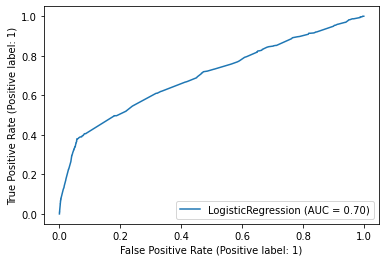

In [80]:
plot_roc_curve(model, X_test[X_test.columns[rfe.support_]], y_test)

## Matriz de confusão desbalanceada

Confusion matrix:
 [[13111  1053]
 [  373   243]]


<ipython-input-81-b9c5a72f4b28>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-81-b9c5a72f4b28>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


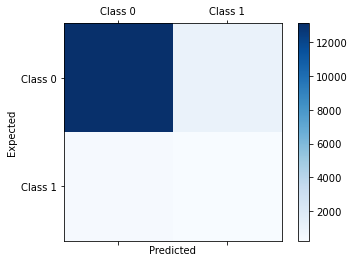

In [81]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

## Matriz de confusão balanceada


Igualamos a proporção de quantidade expected = 0 com expeted = 1

false negative adjusted 8576.577922077922
true negative adjusted 5587.422077922078
[[13111  1053]
 [ 8576  5587]]


<ipython-input-82-a80454fc5115>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-82-a80454fc5115>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


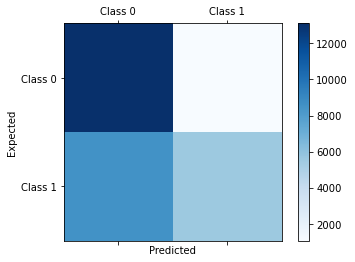

Acurácia: 0.6600536571589947
Recall: 0.3944785709242392
Precisão: 0.8414156626506024


In [82]:
base1 = conf_mat[1].sum()
base2 = conf_mat[0].sum()
print("false negative adjusted",conf_mat[1][0]/base1*base2) 
print("true negative adjusted", conf_mat[1][1]/base1*base2) 

conf_mat2 = conf_mat
conf_mat2[1][0] = conf_mat[1][0]/base1*base2
conf_mat2[1][1] = conf_mat[1][1]/base1*base2

print(conf_mat2)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat2, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

accuracy = (conf_mat2[0][0]+conf_mat2[1][1])/(base2*2)
print('Acurácia:', accuracy)

recall = (conf_mat2[1][1])/(conf_mat2[1][1]+conf_mat2[1][0])
print('Recall:', recall)

precision = (conf_mat2[1][1])/(conf_mat2[1][1]+conf_mat2[0][1])
print('Precisão:', precision)

In [85]:
base_tranf = X
# Transformação (Transform) One Hot Encoding
tr=ohe.transform(base_tranf.loc[:,((base_tranf.dtypes == 'category') | (base_tranf.dtypes == object)).values])
df1 = base_tranf.loc[:,base_tranf.columns[~((base_tranf.dtypes == 'category') | (base_tranf.dtypes == object)).values]]
df2 = pd.DataFrame(tr, columns = ohe.get_feature_names(base_tranf.columns[((base_tranf.dtypes == 'category') | (base_tranf.dtypes == object)).values]), index=df1.index)
X = pd.concat([df1, df2], axis=1)

X = model.predict_proba(X[X.columns[rfe.support_]])

In [91]:
X = pd.DataFrame(X)
X['acesso'] = y.array
X

,0,1,acesso
0,0.603813,0.396187,0
1,0.680619,0.319381,0
2,0.584735,0.415265,0
3,0.727526,0.272474,0
4,0.561431,0.438569,0
...,...,...,...
73894,0.586189,0.413811,0
73895,0.697155,0.302845,0
73896,0.559136,0.440864,0
73897,0.653598,0.346402,0


# Gráficos

<AxesSubplot:>

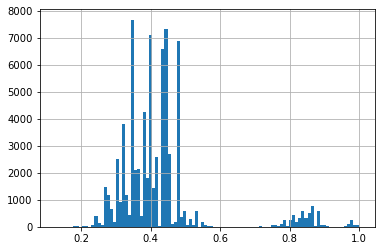

In [92]:
X[1].hist(bins = 100)

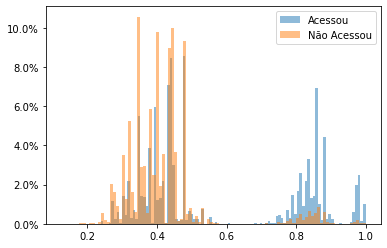

In [95]:
um = X[X["acesso"]==1][1]
zero = X[X["acesso"]==0][1]

plt.hist(um, bins = 100, alpha=0.5, label='Acessou', weights=np.ones(len(um)) / len(um))
plt.hist(zero, bins = 100, alpha=0.5, label='Não Acessou', weights=np.ones(len(zero)) / len(zero))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(loc='upper right')
plt.show()

acesso
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: 1, dtype: object

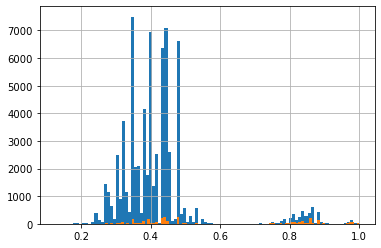

In [96]:
X[1].groupby(X['acesso']).hist(bins=100)

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

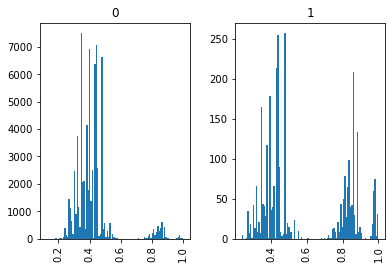

In [97]:
X[1].hist(by=X['acesso'], bins=100)

# Conclusão

- AUC de aproximadamente 0.70
- Acurácia de aproximadamente 0.66
- Recall de aproximadamente 0.40
- Precisão de aproximadamente 0.84
- Ao observar as métricas, o modelo não está suficiente performático para encontrar os casos verdadeiros positivos (em que a coluna 'acesso' possui valor real 1 e o modelo prediz como 1). 
- O recall, principalmente, possui um valor muito baixo. Estamos classificando como clientes que 'não acessariam' muitos dos que na verdade acessariam;
- Apesar de tudo, com a análise dos gráficos podemos perceber que o modelo gerado condiz com a situação problema. Os valores de probabilidade maiores para prdição 'acesso = 1' se encontram com maior frequência em que casos que o valor real da variável é 1
- A probabilidade dos clientes pode ser exportada abaixo

In [ ]:
X.to_csv(r'modelagem.csv', sep=';', encoding='iso8859-1', index=False)